In [1]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import wfdb
#read ludb ecgs
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
DATA_FOLDER = 'physionet.org/files/ludb/1.0.1/data/'
SEGMENT_TO_COLOR = {
    'p': 'red',
    'N': 'blue',
    't': 'green',
}

In [3]:
from typing import Union,List, Tuple

# get signal with wfdb library
# using an index
def get_signal(index:int, as_p_signal:bool=True) -> Union[wfdb.Record, np.ndarray]:
    record = wfdb.rdrecord(DATA_FOLDER + "/" +  str(index))
    assert type(record) is wfdb.Record

    if as_p_signal:
        assert type(record.p_signal) is np.ndarray
        return record.p_signal
        
    return record

# get annotations given the ecg lead
def get_annotations(index:int, lead, as_sample=True) -> Union[wfdb.Annotation, np.ndarray]:
    annotations = wfdb.rdann(DATA_FOLDER +"/" + str(index), extension = lead)
    if as_sample:
        return np.array(annotations.sample)
    return annotations

# get a full EGC with 12 leads
def get_full_ecg(index:int):
    signal = get_signal(index)
    annotations = [
        get_annotations(index, lead) for lead in LEADS
    ]
    return signal, annotations


def get_single_lead_ecg(index, lead) -> Tuple[np.ndarray, np.ndarray]:
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    samples = get_annotations(index, lead)
    assert type(samples) is np.ndarray
    
    return signal, samples


def get_annotations_symbols(index, lead):
    ann = get_annotations(index, lead, as_sample=False)
    return ann.symbol

def paired_annotation_sample_and_symbol(index, lead):
    annotations_symbols = get_annotations_symbols(index, lead)
    annotations_sample = get_annotations(index, lead)
    return zip(annotations_sample, annotations_symbols)


def get_single_lead_ecg_with_symbols(index, lead):
    """
    return and ecg signal and its annotations
    both as ndarray
    """
    signal = get_signal(index)
    assert type(signal) is np.ndarray
    signal = signal[:, LEADS.index(lead)]

    data = paired_annotation_sample_and_symbol(index, lead)
    
    return signal, np.array(list(data))

# plot single lead ecg with annotations
def plot_single_lead_ecg(index, lead):
    signal, samples = get_single_lead_ecg(index, lead)

    fig, ax = plt.subplots(figsize = (28, 3))

    ax.plot(signal)
    ax.scatter(samples, signal[samples], c = 'r', marker = 'o')


# now plot every lead with annotations
def plot_signal_with_annotation(index):
    signal, samples = get_full_ecg(index)
    # extract sample from annotations
    wfdb.plot_items(signal, samples )


In [4]:
"""
Generator that allows to iterate over a list, grouping the elements in groups of n.
Example:
    >>> list(grouped([1,2,3,4,5,6,7,8,9], n=3))
    [(1, 2, 3), (4, 5, 6), (7, 8, 9)]
"""
def grouped(itr, n=3):
    itr = iter(itr)
    end = object()
    while True:
        vals = tuple(next(itr, end) for _ in range(n))
        if vals[-1] is end:
            return
        yield vals

In [45]:
class EGCSignal:
    """
    This class has 4 main purposes:
    1. To store the signal and its annotations
    2. To cut the signal once at the beginning and once at the end
    3. To plot the ECG in different ways
    4. To convert the annotation in a one hot encoding

    Note that doesn't store the entire ECG, but only one lead

    Also has a method to initialize the class without explicitly passing the signal and annotations
    but with the index and lead of the record
    """
    def __init__(self, signal, time_points, symbol, categories = None):
        self.signal:np.ndarray = signal
        self.time_points:np.ndarray = time_points
        self.symbols:list[str] = symbol
        self.symbol_to_category = {
            'N': 0,
            't': 1,
            'p': 2
        }
        self.category_to_symbol = {
            0: 'N',
            1: 't',
            2: 'p'
        }
        self.categories = categories if categories is not None else self.symbols_to_category()
        self._cut_beginning(550)
        self._cut_end( 3500)

    def __getitem__(self, key):
        return self.signal[key]

    def __len__(self):
        return len(self.signal)

    def _cut_beginning(self, start_point):
        self.signal = self.signal[start_point:]
        self.categories = self.categories[start_point:]

        # now have to check if time_points and symbols are also to cut
        if start_point > self.time_points[0]:
            # get the index of the first time point greater than start_point
            index = np.argmax(self.time_points > start_point)                
            self.time_points = self.time_points[index:]
            self.symbols = self.symbols[index:]

        self.time_points = self.time_points - start_point

        # check the cut point
        if self.categories[0] != -1:
            # if the first symbol is a ')' then i have to prepend a '(' and a letter from self.category_to_symbol
            if self.symbols[0] == ')':
                self.symbols = ['('] + [self.category_to_symbol[self.categories[0]]] + self.symbols
                self.time_points = np.concatenate(([0,1], self.time_points))
            elif self.symbols[0] in self.symbol_to_category:
                # just prepend '('
                self.symbols = ['('] + self.symbols
                self.time_points = np.concatenate(([0], self.time_points))

    def _cut_end(self, end_point):
        self.signal = self.signal[:end_point]
        self.categories = self.categories[:end_point]

        index = self.time_points[self.time_points < self.signal.size].size
        self.time_points = self.time_points[:index]
        self.symbols = self.symbols[:index]

        # check the cut point
        if self.categories[-1] != -1:
            # if the last symbol is a '(' then i have to append a ')' and a letter from self.category_to_symbol
            if self.symbols[-1] == '(':
                self.symbols = self.symbols +  [self.category_to_symbol[self.categories[-1]]] + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size - 1, self.signal.size ]))
            elif self.symbols[-1] in self.symbol_to_category:
                # just append ')'
                self.symbols = self.symbols + [')']
                self.time_points = np.concatenate((self.time_points, [self.signal.size]))
 
    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize = (28, 3))
        ax.plot(self.signal)

    def plot_with_time_point(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)
        ax.scatter(self.time_points, self.signal[self.time_points], c = 'r', marker = 'o')

    def plot_with_segments(self):
        fig, ax = plt.subplots(figsize = (28, 3))
        self.plot(ax)

        for start, symbol, end in grouped(self.time_points, 3):            
            i = np.nonzero(self.time_points == symbol)[0][0]
            current_symbol = self.symbols[i]
            color = SEGMENT_TO_COLOR[current_symbol]
            ax.axvspan(start, end, color=color, alpha=0.4)

    def symbols_to_category(self):
        """
        converts the symbols list in a numpy array of integers
        same length as the signal
        """

        # first instantiate an array of -1 same length as the signal
        category = np.full(len(self.signal), -1)
        # now fill the array with the known category
        for section in grouped(self.time_points):
            # unpack the section
            start, peak, end = section
            
            
            # get the category given the peak
            i = np.nonzero(self.time_points == peak)[0][0]
            current_symbol = self.symbols[i]
            category[start:end] = self.symbol_to_category[current_symbol]

        return category

    @staticmethod
    def from_index_and_lead(index, lead):
        return EGCSignal(
        get_signal(index)[:, LEADS.index(lead)],
        get_annotations(index, lead),
        get_annotations_symbols(index, lead) )



In [46]:
X = np.zeros((200, 12, 3500))
for i in range(1,201):
    for j, lead in enumerate(LEADS):
        print (i, lead)
        EGCSignal.from_index_and_lead(i, lead).signal

1 avf
1 avl
1 avr
1 i
1 ii
1 iii
1 v1
1 v2
1 v3
1 v4
1 v5
1 v6
2 avf
2 avl
2 avr
2 i
2 ii
2 iii
2 v1
2 v2
2 v3
2 v4
2 v5
2 v6
3 avf
3 avl
3 avr
3 i
3 ii
3 iii
3 v1
3 v2
3 v3
3 v4
3 v5
3 v6
4 avf
4 avl
4 avr
4 i
4 ii
4 iii
4 v1
4 v2
4 v3
4 v4
4 v5
4 v6
5 avf
5 avl
5 avr
5 i
5 ii
5 iii
5 v1
5 v2
5 v3
5 v4
5 v5
5 v6
6 avf
6 avl
6 avr
6 i
6 ii
6 iii
6 v1
6 v2
6 v3
6 v4
6 v5
6 v6
7 avf
7 avl
7 avr
7 i
7 ii
7 iii
7 v1


KeyError: ')'

In [122]:
EGCSignal.from_index_and_lead(1, LEADS[0]).signal

array([-0.07342657, -0.02855478,  0.01689977, ...,  0.11013986,
        0.10839161,  0.10780886])

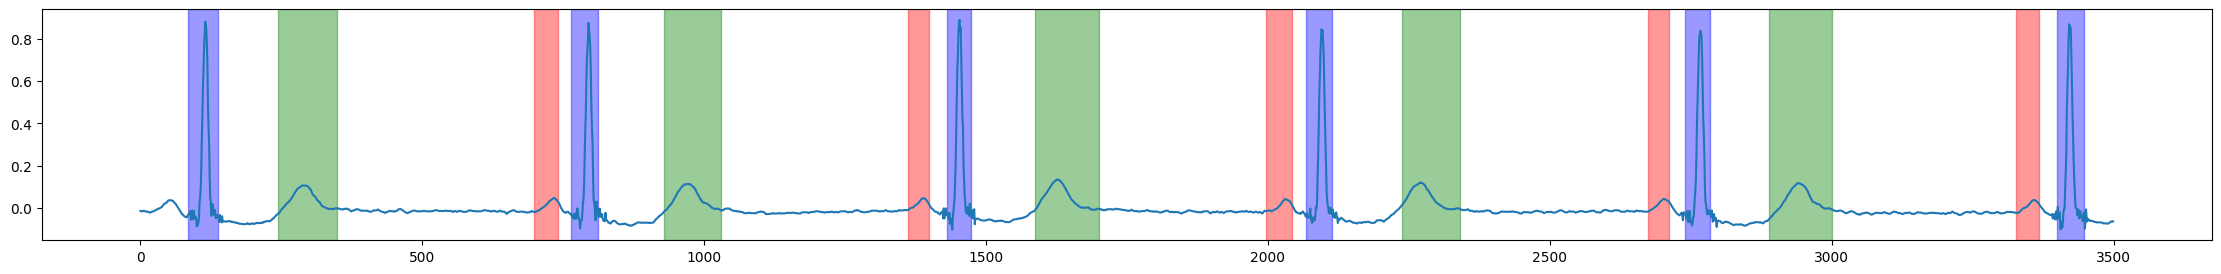

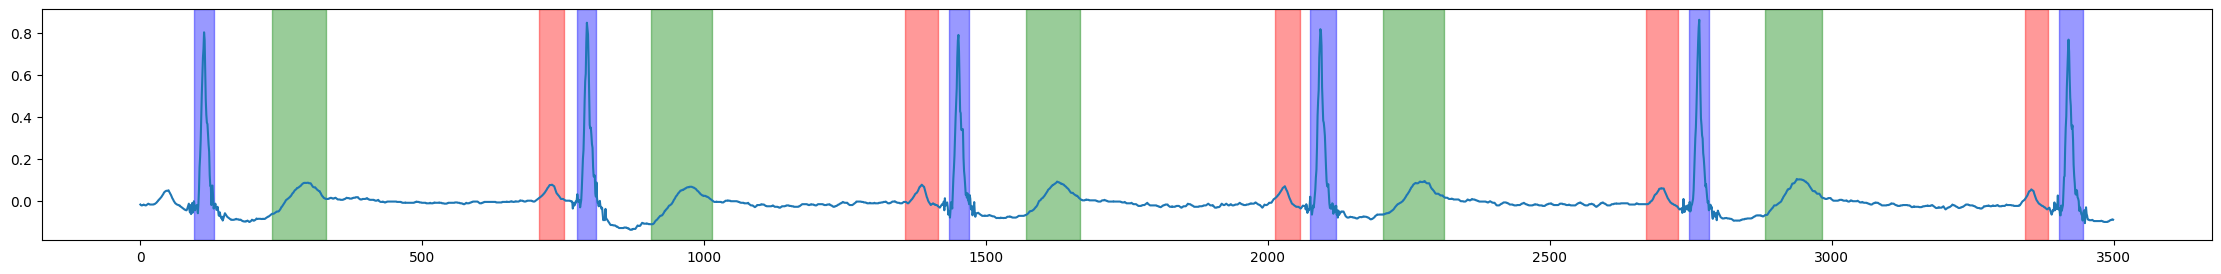

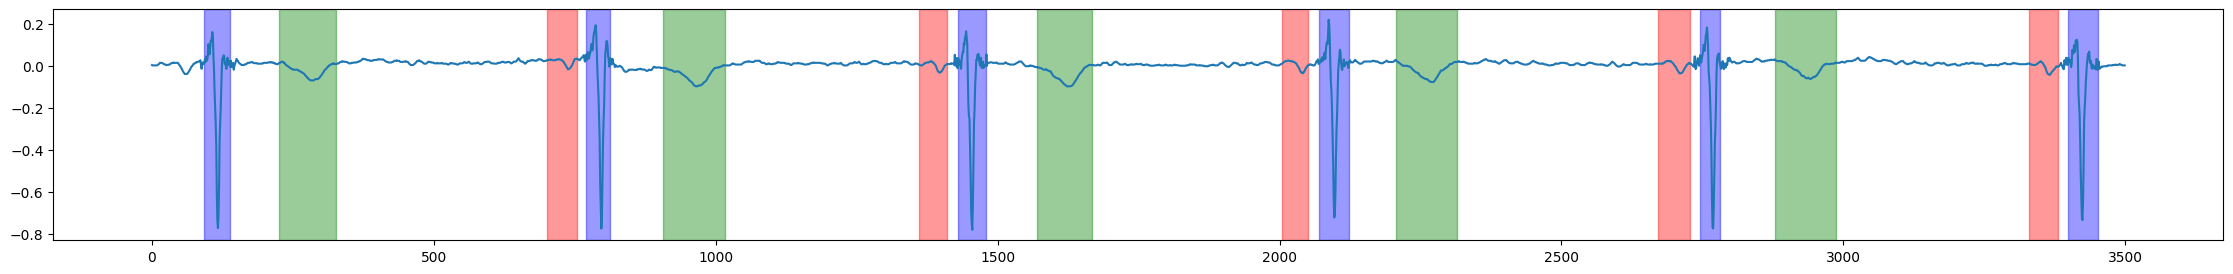

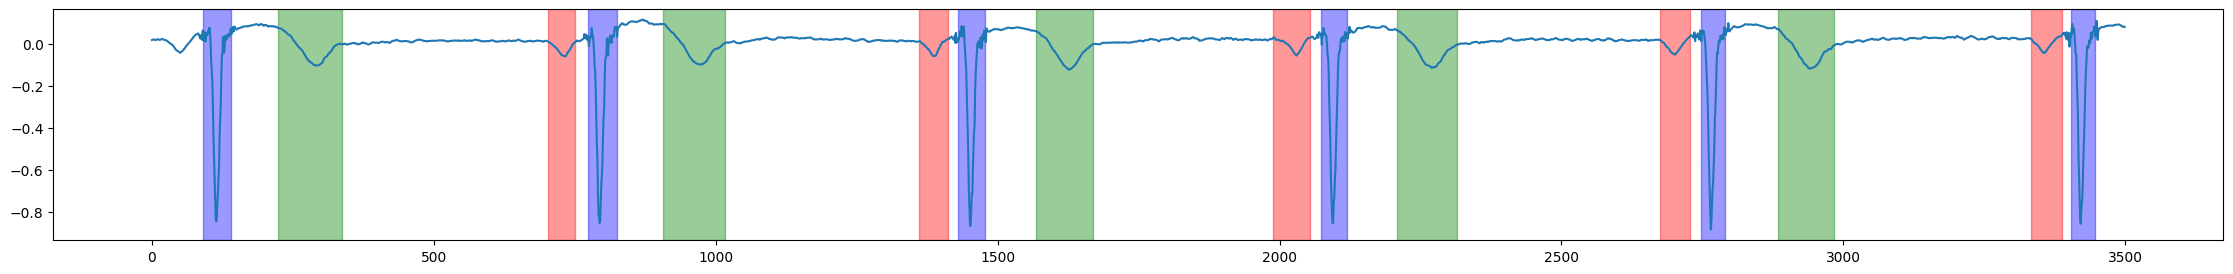

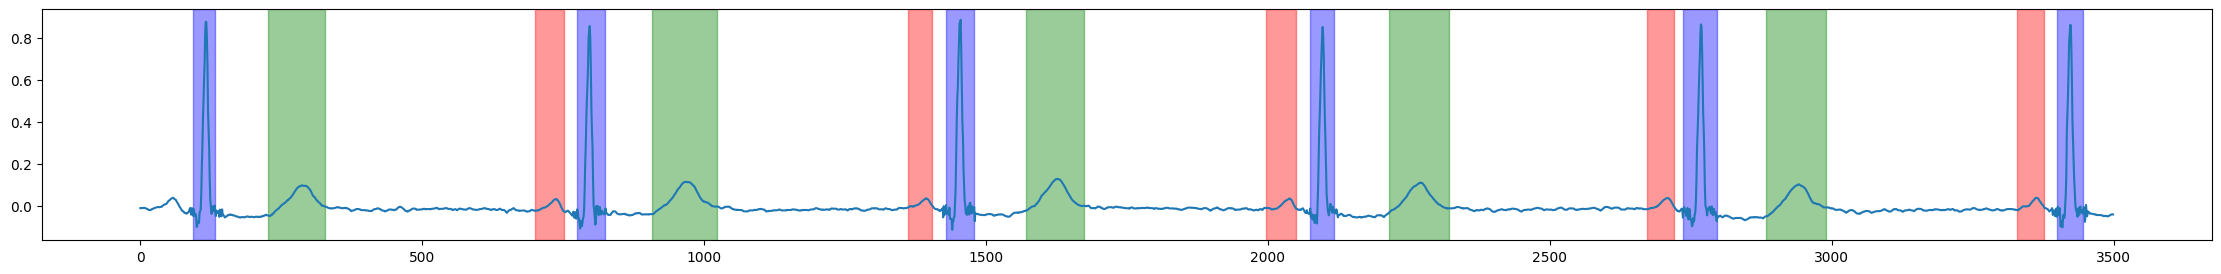

In [96]:
EGCSignal.from_index_and_lead(1, LEADS[0]).plot_with_segments()
EGCSignal.from_index_and_lead(1, LEADS[1]).plot_with_segments()
EGCSignal.from_index_and_lead(1, LEADS[2]).plot_with_segments()
EGCSignal.from_index_and_lead(1, LEADS[3]).plot_with_segments()
EGCSignal.from_index_and_lead(1, LEADS[4]).plot_with_segments()

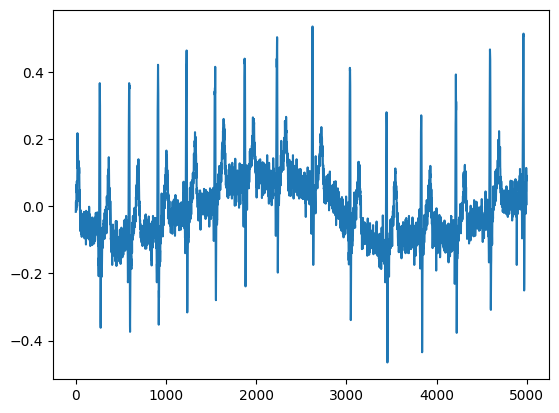

In [49]:
plt.plot(v1s[0][4])

In [50]:
from unet import UNet

In [3]:
from unet import UNet
import torch
x = torch.randn(64, 12, 2500)
model = UNet(12, 2)
model(x).shape

torch.Size([64, 2, 2500])

In [1]:
model(x).shape

NameError: name 'model' is not defined